# Spatial Coarse-Graining of TAP and Mean-Field Inference Algorithms

In [2]:
%pylab inline
import sys, importlib
sys.path.append('../code')
from notebookutils import *
# Also import modules using aliases so I can reload them when I make an edit
import notebookutils as ntutils
import tapdynamics as tap
import particlefilter as pfil
importlib.reload(ntutils)
importlib.reload(tap)
importlib.reload(pfil)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<module 'particlefilter' from '/its/home/cg610/coarse_graining_algorithms/coarse_graining_algorithms/notebooks/../code/particlefilter.py'>

### Here, we simulate the updating of marginal beliefs over latent states under both the TAP and mean-field inference algorithms

In [8]:
def get_dynamics(Ns, Nr, Ny, B_train, T): 
    np.random.seed(13)
    ##################
    # These parameters are not used since the connections to observations to latent states are zeroed out                             
    T_low, T_high = T, T+1           # range of time periods for which input is held constant: T and T+1 means constant for entire period
    yG_low, yG_high = np.sqrt(Ns), np.sqrt(Ns)   # These input gains give us binary observations


    # process and observation noise covariance matrices
    q_process, q_obs = 0, 0
    Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

    # filter used for smoothing the input signals
    # Carter changed from signal.hamming to signal.windows.hamming 
    smoothing_filter = signal.windows.hamming(5,sym=True) 
    smoothing_filter = smoothing_filter/sum(smoothing_filter)


    # lam controls how much new messages update activation
    lam = np.array([1])  # No low pass filter
    # The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
    # the exponent of J, x_i, and x_j. 
    G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
    G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters

    # Connectivity matrix between state nodes
    # Ns x Ns

    J = np.array([
    [0, 100, 0, 0],
    [100, 0, 100, 0],
    [0, 100, 0, -1],
    [0, 0, -1, 0]
    ])
    J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1 to avoid oscillations of TAP

    if Ns == 3:
        J = J[1:,1:]
        

    # Connectivity matrix between state and observation nodes
    # Ns x Ny
    # if Ns <= Ny:
    #     V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
    # else:
    #     V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
    V = np.zeros((Ns,Ny))  # No input dependence

    # Empty embedding matrix because we don't care about neural response
    embedding_arr = (Nr,Ns)
    U = np.zeros(embedding_arr)

    # Combine all parameters into single vector
    theta_TAP = np.concatenate([lam, G_TAP, JMatToVec(J), U.flatten('F'), V.flatten('F') ])
    theta_MF = np.concatenate([lam, G_MF, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

    # Put in filler values for unused parameters
    self_coupling_on = False
    sparsity_J = 0.0
    Jtype = 'nonferr'  # full, sparse, or diag

    params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

    ##################
    # Specify sampling or message passing function
    # runTAP - message passing
    # runTAPSampling - sampling
    TAP_func=runTAP
    input = generate_input_binary(B_train, Ny, T-1)
    initial_x = np.random.rand(Ns,B_train) 	
    y_train_TAP, x_train_TAP, r_train_TAP = tap.generate_TAPdynamics(theta_TAP, params, B_train, T, T_low, T_high, yG_low, yG_high,{},{},input,initial_x,TAP_func=TAP_func)
    y_train_MF, x_train_MF, r_train_MF = tap.generate_TAPdynamics(theta_MF, params, B_train, T, T_low, T_high, yG_low, yG_high,{},{},input,initial_x,TAP_func=TAP_func)

    # For validating the inference over G
    G_inferred_MF = tap.infer_exact_G_all_timepoints(y_train_MF, x_train_MF, params,theta_MF) 
    G_inferred_TAP = tap.infer_exact_G_all_timepoints(y_train_TAP, x_train_TAP, params,theta_TAP)

    return y_train_TAP, x_train_TAP, r_train_TAP, y_train_MF, x_train_MF, r_train_MF, J



Ns=4
Nr=2
Ny=4
B_train=1
T=16
y_train_TAP, x_train_TAP_4, r_train_TAP, y_train_MF, x_train_MF_4, r_train_MF, J_4 = get_dynamics(Ns, Nr, Ny, B_train, T)

Ns=3
Nr=2
Ny=3
B_train=1
T=16
y_train_TAP, x_train_TAP_3, r_train_TAP, y_train_MF, x_train_MF_3, r_train_MF, J_3 = get_dynamics(Ns, Nr, Ny, B_train, T) 

# Final TAP and MF latents for four nodes
x_train_TAP_4_final = x_train_TAP_4[:, :, -1]
x_train_MF_4_final = x_train_MF_4[:, :, -1] 
# Final TAP and MF latents for three nodes
x_train_TAP_3_final = x_train_TAP_3[:, :, -1]
x_train_MF_3_final = x_train_MF_3[:, :, -1]

# Print final latents
print("Final MF latents (4 nodes):", x_train_MF_4_final)
print("Final TAP latents (4 nodes):", x_train_TAP_4_final)
print("Final MF latents (3 nodes):", x_train_MF_3_final)
print("Final TAP latents (3 nodes):", x_train_TAP_3_final)

Final MF latents (4 nodes): [[0.62239696 0.7067403  0.62156752 0.49890123]]
Final TAP latents (4 nodes): [[0.7382339  0.82883833 0.73700314 0.49739425]]
Final MF latents (3 nodes): [[0.60527072 0.60454946 0.49893131]]
Final TAP latents (3 nodes): [[0.69298953 0.69201357 0.49755345]]


### Let's visualize the change in the latent state probability over time

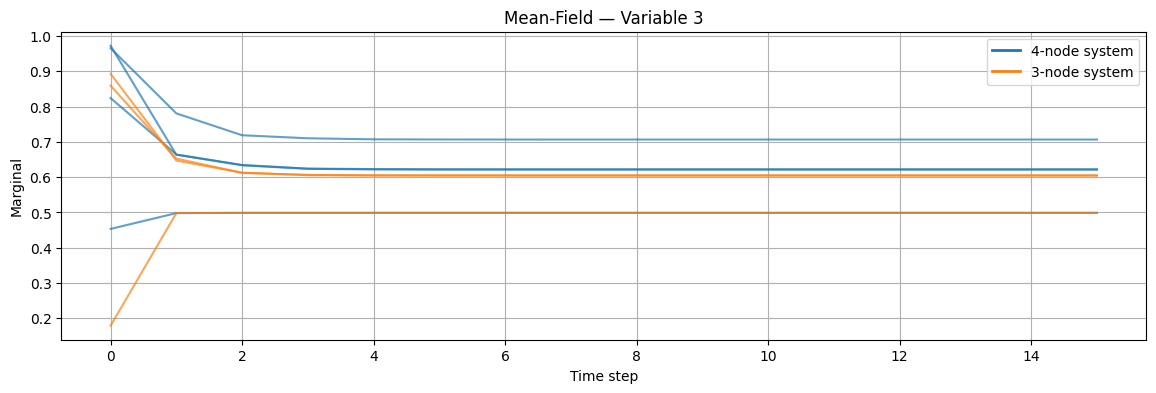

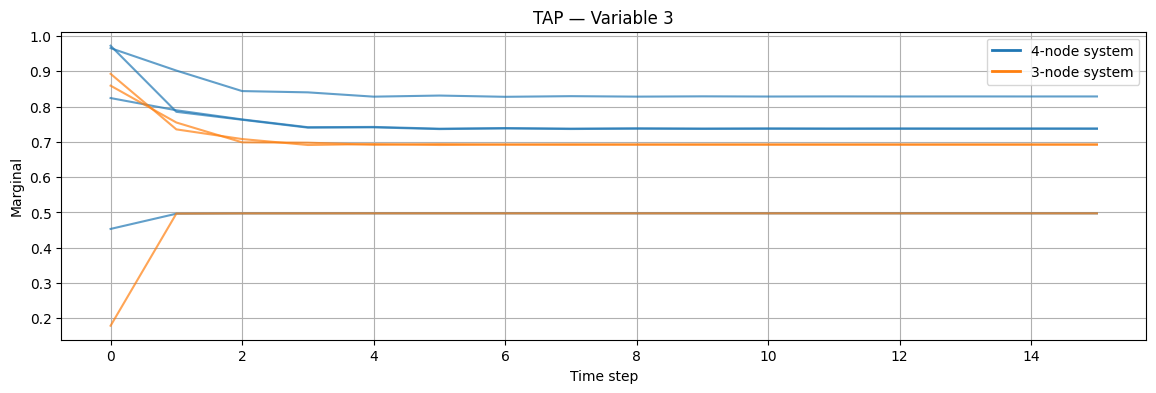

In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


var = 2   # variable 3 (0-indexed)

plt.figure(figsize=(14,4))

# 4-node system → 4 trajectories
for b in range(x_train_MF_4.shape[1]):
    plt.plot(x_train_MF_4[0, b, :], color="tab:blue", alpha=0.7)

# 3-node system → 3 trajectories
for b in range(x_train_MF_3.shape[1]):
    plt.plot(x_train_MF_3[0, b, :], color="tab:orange", alpha=0.7)

plt.title("Mean-Field — Variable 3")
plt.xlabel("Time step")
plt.ylabel("Marginal")
plt.grid(True)

legend_handles = [
    Line2D([0], [0], color="tab:blue", lw=2, label="4-node system"),
    Line2D([0], [0], color="tab:orange", lw=2, label="3-node system")
]

plt.legend(handles=legend_handles)
plt.show()

plt.figure(figsize=(14,4))

for b in range(x_train_TAP_4.shape[1]):
    plt.plot(x_train_TAP_4[0, b, :], color="tab:blue", alpha=0.7)

for b in range(x_train_TAP_3.shape[1]):
    plt.plot(x_train_TAP_3[0, b, :], color="tab:orange", alpha=0.7)

plt.title("TAP — Variable 3")
plt.xlabel("Time step")
plt.ylabel("Marginal")
plt.grid(True)

legend_handles = [
    Line2D([0], [0], color="tab:blue", lw=2, label="4-node system"),
    Line2D([0], [0], color="tab:orange", lw=2, label="3-node system")
]

plt.legend(handles=legend_handles)
plt.show()


## Spatial Coarse-Grain Using Renormalization Group
### See "Criticality and Decimation in the Ising Model for d = 1 and d = 2." Berean-Dutcher, 2021


In [5]:
def get_macro_latents(x_train_MF, x_train_TAP, Ns, Nr, T,J_micro):
    B_train = 1
    # Decimate the redundant node (node 3)
    macro_TAP =  np.delete(x_train_TAP, 2, axis=1)
    macro_MF = np.delete(x_train_MF, 2, axis=1)

    Ns_macro = Ns - 1

    # Infer G on coarse-grained data
    # Fill observatinos with zeros since we don't care about them
    macro_y = np.zeros((B_train, Ns_macro, T-1))
    Ny_macro = Ns_macro
    macro_embedding_arr = (Nr,Ns_macro)
    V = np.zeros((Ns_macro,Ny_macro))  # No input dependence

    # Make coarse-grained coupling matrix
    J_macro = J_micro[1:,1:]

    
    U_macro = np.zeros(macro_embedding_arr)

    # lam controls how much new messages update activation
    lam = np.array([1])  # No low pass filter
    # The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
    # the exponent of J, x_i, and x_j. 
    G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
    G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters

    macro_theta_TAP= np.concatenate([lam, G_TAP, JMatToVec(J_macro), U_macro.flatten('F'), V.flatten('F') ])
    macro_theta_MF = np.concatenate([lam, G_MF, JMatToVec(J_macro), U_macro.flatten('F'), V.flatten('F') ])

    # Filler values for unused parameters
    q_process, q_obs = 0, 0
    Q_process, Q_obs = q_process*np.eye(Ns_macro), q_obs*np.eye(Nr)   
    smoothing_filter = signal.windows.hamming(5,sym=True) 
    smoothing_filter = smoothing_filter/sum(smoothing_filter)
 

    macro_params = {'Ns':Ns_macro,'Ny':Ny_macro,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns_macro),'smoothing_filter':smoothing_filter,'self_coupling_on':0,'sparsity_J':.5,'Jtype':"nonferr"  }

    return macro_TAP, macro_MF, macro_theta_TAP, macro_theta_MF, macro_y, macro_params

In [7]:
J_micro = J_4
macro_TAP, macro_MF, macro_theta_TAP, macro_theta_MF, macro_y, macro_params = get_macro_latents(x_train_MF_4, x_train_TAP_4, 4, Nr, T,J_micro)

G_coarse_inferred_TAP = tap.infer_exact_G_all_timepoints(macro_y, macro_TAP, macro_params,macro_theta_TAP)
G_coarse_inferred_MF = tap.infer_exact_G_all_timepoints(macro_y, macro_MF, macro_params,macro_theta_MF)


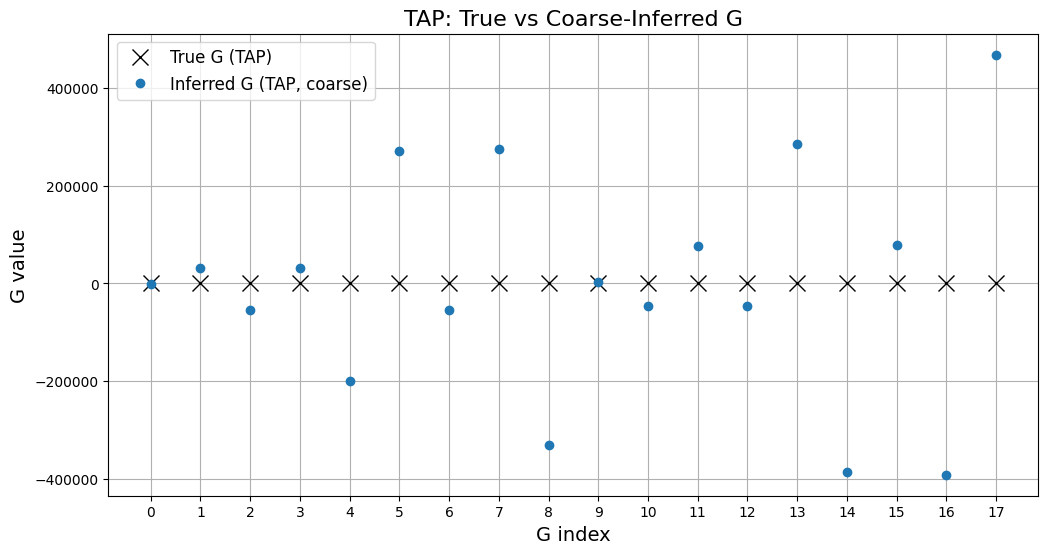

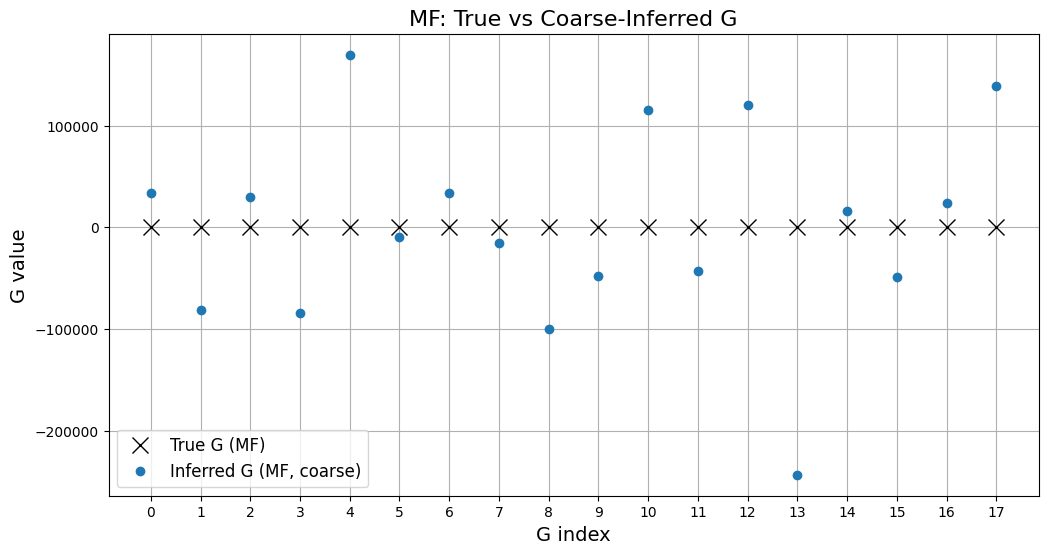

In [18]:
# Plot results!
import matplotlib.pyplot as plt
import numpy as np

G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters


# Extract vectors (assume batch dimension = 1)
G_inf_TAP = G_coarse_inferred_TAP[0]
G_true_TAP = G_TAP[0] if G_TAP.ndim == 2 else G_TAP

x = np.arange(len(G_true_TAP))

plt.figure(figsize=(12, 6))

plt.plot(x, G_true_TAP, 'x', markersize=12,color="black", label="True G (TAP)")
plt.plot(x, G_inf_TAP, '.', markersize=12, label="Inferred G (TAP, coarse)")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("TAP: True vs Coarse-Inferred G", fontsize=16)

plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(x)

plt.show()

# Extract vectors
G_inf_MF = G_coarse_inferred_MF[0]
G_true_MF = G_MF[0] if G_MF.ndim == 2 else G_MF

x = np.arange(len(G_true_MF))

plt.figure(figsize=(12, 6))

plt.plot(x, G_true_MF, 'x', markersize=12, color="black",label="True G (MF)")
plt.plot(x, G_inf_MF, '.', markersize=12, label="Inferred G (MF, coarse)")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("MF: True vs Coarse-Inferred G", fontsize=16)

plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(x)

plt.show()



## Repeat this analysis on a bigger lattice

In [ ]:
Ns=441
Nr=2
Ny=441
B_train=1
T=16
y_train_TAP, x_train_TAP, r_train_TAP, y_train_MF, x_train_MF, r_train_MF = get_dynamics(Ns, Nr, Ny, B_train, T)

# Estimate J on coarse-grained lattice keeping only even nodes
J = square_lattice_J(int(np.sqrt(Ns)))
J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1 to avoid oscillations of TAP
# First get the coupling coefficient
J_coef = max(np.unique(J))
# Estimate J using the formula derived for 2D lattice
# using Migdal-Kadanoff approximation
estimated_J_coef = .5*np.log(np.cosh(4*J_coef))


macro_TAP, macro_MF, macro_theta_TAP, macro_theta_MF, macro_y, macro_params = get_macro_latents(x_train_MF, x_train_TAP, Ns, Nr, T,estimated_J_coef)

G_coarse_inferred_TAP = tap.infer_exact_G_all_timepoints(macro_y, macro_TAP, macro_params,macro_theta_TAP)
G_coarse_inferred_MF = tap.infer_exact_G_all_timepoints(macro_y, macro_MF, macro_params,macro_theta_MF)
print("Coarse-grained inferred G (TAP): ", G_coarse_inferred_TAP[0])
print("Coarse-grained inferred G (MF): ", G_coarse_inferred_MF[0])


## Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract vectors (assume batch dimension = 1)
G_inf_TAP = G_coarse_inferred_TAP[0]
G_true_TAP = G_TAP[0] if G_TAP.ndim == 2 else G_TAP

x = np.arange(len(G_true_TAP))

plt.figure(figsize=(12, 6))

plt.plot(x, G_true_TAP, 'x', markersize=12,color="black", label="True G (TAP)")
plt.plot(x, G_inf_TAP, '.', markersize=12, label="Inferred G (TAP, coarse)")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("TAP: True vs Coarse-Inferred G", fontsize=16)

plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(x)

plt.show()

# Extract vectors
G_inf_MF = G_coarse_inferred_MF[0]
G_true_MF = G_MF[0] if G_MF.ndim == 2 else G_MF

x = np.arange(len(G_true_MF))

plt.figure(figsize=(12, 6))

plt.plot(x, G_true_MF, 'x', markersize=12, color="black",label="True G (MF)")
plt.plot(x, G_inf_MF, '.', markersize=12, label="Inferred G (MF, coarse)")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("MF: True vs Coarse-Inferred G", fontsize=16)

plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(x)

plt.show()



## Loop through lattice sizes and apply spatial coarse-graining

In [ ]:
odd_integers = list(range(5, 52, 2))

G_TAP_by_N = {}
G_MF_by_N  = {}

for lattice_size in odd_integers:
    Ns = lattice_size**2
    Nr=2
    Ny=Ns
    B_train=1
    T=16
    y_train_TAP, x_train_TAP, r_train_TAP, y_train_MF, x_train_MF, r_train_MF = get_dynamics(Ns, Nr, Ny, B_train, T)

    # Estimate J on coarse-grained lattice keeping only even nodes
    J = square_lattice_J(int(np.sqrt(Ns)))
    J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1 to avoid oscillations of TAP
    # First get the coupling coefficient
    J_coef = max(np.unique(J))
    # Estimate J using the formula derived for 2D lattice
    # using Migdal-Kadanoff approximation
    estimated_J_coef = .5*np.log(np.cosh(4*J_coef))


    macro_TAP, macro_MF, macro_theta_TAP, macro_theta_MF, macro_y, macro_params = get_macro_latents(x_train_MF, x_train_TAP, Ns, Nr, T,estimated_J_coef)

    G_coarse_inferred_TAP = tap.infer_exact_G_all_timepoints(macro_y, macro_TAP, macro_params,macro_theta_TAP)
    G_coarse_inferred_MF = tap.infer_exact_G_all_timepoints(macro_y, macro_MF, macro_params,macro_theta_MF)
    G_TAP_by_N[Ns] = G_coarse_inferred_TAP
    G_MF_by_N[Ns]  = G_coarse_inferred_MF





In [ ]:
# Plot the difference between true and inferred G values as a function of Ns
import numpy as np

Ns_vals = sorted(G_TAP_by_N.keys())

TAP_err = []
MF_err  = []

for Ns in Ns_vals:
    G_TAP_tuple = G_TAP_by_N[Ns]
    G_MF_tuple  = G_MF_by_N[Ns]

    # Frobenius norm across all timepoints
    TAP_norm = np.linalg.norm(G_TAP_tuple[0]-G_true_TAP,2)
    MF_norm  = np.linalg.norm(G_MF_tuple[0]-G_true_MF,2)

    TAP_err.append(TAP_norm)
    MF_err.append(MF_norm)




plt.figure()
plt.plot(Ns_vals, TAP_err, marker='o')
plt.xlabel("Ns (lattice size)")
plt.ylabel("L2 Norm")
plt.title("Difference between true and inferred algorithm vs lattice size for TAP")
plt.grid(True)
plt.show()



plt.figure()
plt.plot(Ns_vals, MF_err, marker='o')
plt.xlabel("Ns (lattice size)")
plt.ylabel("L2 Norm")
plt.title("Difference between true and inferred algorithm vs lattice size for MF")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))

Ns_plot = Ns_vals[5:]
norm = plt.Normalize(vmin=min(Ns_plot), vmax=max(Ns_plot))
cmap = plt.cm.viridis

for Ns in Ns_plot:
    G = G_TAP_by_N[Ns][0]
    G_vec = G.flatten()
    idx = np.arange(len(G_vec))

    # IMPORTANT: use c= with an array, not color=
    plt.scatter(idx, G_vec, s=30, c=[Ns]*len(idx), cmap=cmap, norm=norm)

plt.colorbar(label="Ns")

plt.xlabel("G index")
plt.ylabel("Coefficient")
plt.title("Inference of Coarse-Grained TAP vs Network Size")
plt.grid(True)
plt.show()



####### Plot MF coarse operator spectra vs index for different Ns

plt.figure(figsize=(6,4))

Ns_plot = Ns_vals[5:]
norm = plt.Normalize(vmin=min(Ns_plot), vmax=max(Ns_plot))
cmap = plt.cm.viridis

for Ns in Ns_plot:
    G = G_MF_by_N[Ns][0]
    G_vec = G.flatten()
    idx = np.arange(len(G_vec))

    # IMPORTANT: use c= with an array, not color=
    plt.scatter(idx, G_vec, s=30, c=[Ns]*len(idx), cmap=cmap, norm=norm)

plt.colorbar(label="Ns")

plt.xlabel("G index")
plt.ylabel("Coefficient")
plt.title("Inference of Coarse-Grained MF vs Network Size")
plt.grid(True)
plt.show()
